In [100]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential, load_model
from CNN import get_wv_matrix
import gensim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
%matplotlib inline
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import h5py
import sys

In [3]:
dev_set_ids = np.load('dev_set_text_ids.npy')
w2vec_model = gensim.models.Word2Vec.load('w2vec_genism')
vocabulary = w2vec_model.wv.vocab

In [6]:
seq_len = []

for post in dev_set_ids:
    seq_len.append(len(post))



1395

In [30]:
words_to_consider = 100
data=pad_sequences(dev_set_ids, maxlen=words_to_consider, padding='post', truncating='post', value=0)
data

array([[   46,   127,   117, ...,     0,     0,     0],
       [ 1214,    43,   897, ...,     0,     0,     0],
       [   13,    32,   100, ...,     0,     0,     0],
       ..., 
       [ 1306,  1343,    45, ...,     0,     0,     0],
       [59703, 59703,   452, ..., 59703,     0,     0],
       [   46,    24,    53, ...,     0,     0,     0]], dtype=int32)

In [27]:
embedding_matrix = get_wv_matrix(w2vec_model)

In [31]:
embeddings = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                      weights=[embedding_matrix], input_length = words_to_consider)


In [29]:
sequence_input = Input(shape=(words_to_consider,), dtype='int32')
embedded_sequences = embeddings(sequence_input)
x = Conv1D(128, 5)

## ok lets test it out

In [4]:
#first need f1 score

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [5]:
dev_set_ids = np.load('dev_set_text_ids.npy')
dev_set_labels = np.load('dev_set_labels')
w2vec_model = gensim.models.Word2Vec.load('w2vec_genism')
vocabulary = w2vec_model.wv.vocab

In [86]:
#split into train, test split
words_to_consider = 100
data=pad_sequences(dev_set_ids, maxlen=words_to_consider, padding='post', truncating='post', value=0)

dev_set_ids.shape[0]==dev_set_labels.shape[0]

x_train, x_validate, y_train, y_validate = train_test_split(data, dev_set_labels, 
                                                            test_size=0.2, random_state=42)


In [87]:
embedding_matrix = get_wv_matrix(w2vec_model)

embeddings = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                      weights=[embedding_matrix], input_length = words_to_consider)


cnn_test = Sequential()

#first conv layer + max pool
cnn_test.add(embeddings)
cnn_test.add(Conv1D(filters=100, kernel_size = 5, activation = 'relu', strides = 1))
cnn_test.add(MaxPooling1D(5))

# #2nd conv layer + max pooling
# cnn_test.add(Conv1D(filters =100, kernel_size = 2, activation='relu'))
# cnn_test.add(MaxPooling1D(5))

#flatten and then connect
cnn_test.add(Flatten())
cnn_test.add(Dense(256, activation = 'relu'))

#output layer with sigmoid activation
cnn_test.add(Dense(y_train.shape[1], activation = 'sigmoid'))

# Compile settings
print('\tcompiler settings complete!')
cnn_test.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1])

cnn_test.fit(x_train, y_train, validation_data=(x_validate, y_validate), epochs = 5, batch_size= 1000, verbose=2)

	compiler settings complete!
Train on 501932 samples, validate on 125484 samples
Epoch 1/5
 - 316s - loss: 0.1275 - f1: 0.6359 - val_loss: 0.0901 - val_f1: 0.7802
Epoch 2/5
 - 313s - loss: 0.0845 - f1: 0.7932 - val_loss: 0.0855 - val_f1: 0.7892
Epoch 3/5
 - 312s - loss: 0.0775 - f1: 0.8108 - val_loss: 0.0848 - val_f1: 0.7941
Epoch 4/5
 - 313s - loss: 0.0716 - f1: 0.8254 - val_loss: 0.0859 - val_f1: 0.7955
Epoch 5/5
 - 312s - loss: 0.0655 - f1: 0.8408 - val_loss: 0.0881 - val_f1: 0.7925


In [55]:
cnn_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 150)          8955300   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 100)           75100     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 19, 100)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 18, 100)           20100     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 3, 100)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               77056     
__________

In [56]:
cnn_test.save('cnn_model.h5')

Now lets predict

In [6]:
x_test = np.load('hold_set_text_ids.npy')
y_test = np.load('hold_set_labels')

words_to_consider = 100

x_test=pad_sequences(x_test, maxlen=words_to_consider, padding='post', truncating='post', value=0)


In [10]:
model =load_model('cnn_model.h5', custom_objects={"f1": f1})


In [88]:
y_predict = cnn_test.predict(x_test, batch_size=1000)

In [89]:
y_rounded = np.round(y_predict)
y_rounded

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [90]:
f1_score(y_test, y_rounded, average='macro')

0.77172837930078542

In [11]:
y_predict1 = model.predict(x_test, batch_size=1000)

In [13]:
y_rounded = np.round(y_predict1)
cnn_f1 = f1_score(y_test, y_rounded, average='macro')

In [91]:
cnn_f1

0.77122382989816884

# Other models

In [31]:
X= np.load('dev_set_text')
Y = np.load('dev_set_labels')
X_test = np.load('hold_set_text')

In [21]:
vect_pkl_filename = 'Tfidf_vect_trigrams.pkl'
vect_model_pkl = open(vect_pkl_filename, 'rb')
tfid_vect_model = pickle.load(vect_model_pkl)
vect_model_pkl.close()

In [32]:

X_transform = tfid_vect_model.transform(X)

SVC_classifier = OneVsRestClassifier(LinearSVC())
SVC_classifier.fit(X_transform, Y)

X_test_bigram = tfid_vect_model.transform(X_test)
prediction_bigram = SVC_classifier.predict(X_test_bigram)

print(f1_score(y_test, prediction_bigram, average='macro'))

0.731728843387


In [34]:
svc_f1= f1_score(y_test, prediction_bigram, average='macro')
svc_f1

0.73172884338662714

In [36]:
LR_classifier = OneVsRestClassifier(LogisticRegression(solver="sag"))
LR_classifier.fit(X_transform, Y)

X_test_bigram = tfid_vect_model.transform(X_test)
LR_predict = LR_classifier.predict(X_test_bigram)

LR_f1 = f1_score(y_test, LR_predict, average='macro')
print(LR_f1)

0.718608883326


In [37]:
NB_classifier = OneVsRestClassifier(MultinomialNB())
NB_classifier.fit(X_transform, Y)

X_test_bigram = tfid_vect_model.transform(X_test)
NB_predict = NB_classifier.predict(X_test_bigram)

NB_f1 = f1_score(y_test, NB_predict, average='macro')
print(NB_f1)

0.634222498244


In [42]:
RF_classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight="balanced"))
RF_classifier.fit(X_transform, Y)

X_test_bigram = tfid_vect_model.transform(X_test)
RF_predict = RF_classifier.predict(X_test_bigram)

RF_f1 = f1_score(y_test, RF_predict, average='macro')
print(RF_f1)

0.664431672466


In [51]:
f1_scores = pd.Series([NB_f1, RF_f1, LR_f1, svc_f1, cnn_f1], index = ['MNB', 'RF', 'LR', 'SVC', 'CNN'])

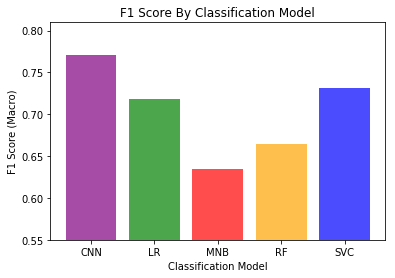

In [80]:
color_map = ['red','orange', 'green', 'blue', 'purple']
plt.bar(f1_scores.index, f1_scores.values, alpha=0.7, color=color_map)
plt.ylim(ymin=0.55)
plt.title('F1 Score By Classification Model')
plt.ylabel('F1 Score (Macro)')
plt.xlabel('Classification Model')
None
    

In [97]:
models = [NB_classifier, LR_classifier, SVC_classifier]
names = ['NB_classifier', 'LR_classifier', 'SVC_classifier']
for model, name in zip(models, names):
    pickle_file = open(name+'.pkl', 'wb')
    pickle.dump(model, pickle_file)
    pickle_file.close()
    

In [96]:
pickle.dump(RF_classifier, open('RF_classifier.pkl', 'wb'))

OSError: [Errno 22] Invalid argument

In [98]:
def save_as_pickled_object(obj, filepath):
    """
    This is a defensive way to write pickle.write, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])


def try_to_load_as_pickled_object_or_None(filepath):
    """
    This is a defensive way to write pickle.load, allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)
    except:
        return None
    return obj

In [101]:
save_as_pickled_object(RF_classifier, 'RF_classifier.pkl')

In [102]:
RF_reloaded = try_to_load_as_pickled_object_or_None("RF_classifier.pkl")